In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 95% 310M/325M [00:02<00:00, 177MB/s]
100% 325M/325M [00:02<00:00, 135MB/s]


In [ ]:
import zipfile
import os

# Specify the path to the downloaded zip file in Colab
zip_file_path = '/content/skin-cancer-malignant-vs-benign.zip'

# Specify the directory where you want to extract the contents in Colab
extracted_folder_path = '/content'

# Create the extraction folder if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extracted_folder_path)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint


In [ ]:
train_path = '/content/train'
test_path = '/content/test'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
img_size = (150, 150)
batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2637 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 660 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')]
)

Epoch 1/50
83/83 [==============================] - 22s 228ms/step - loss: 0.6400 - accuracy: 0.6109 - val_loss: 0.4727 - val_accuracy: 0.7348
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 18s 211ms/step - loss: 0.4442 - accuracy: 0.7797 - val_loss: 0.4204 - val_accuracy: 0.7758
Epoch 3/50
83/83 [==============================] - 18s 212ms/step - loss: 0.4214 - accuracy: 0.7888 - val_loss: 0.4168 - val_accuracy: 0.7879
Epoch 4/50
83/83 [==============================] - 18s 221ms/step - loss: 0.4088 - accuracy: 0.8005 - val_loss: 0.3923 - val_accuracy: 0.7879
Epoch 5/50
83/83 [==============================] - 17s 209ms/step - loss: 0.3706 - accuracy: 0.8153 - val_loss: 0.4202 - val_accuracy: 0.7848
Epoch 6/50
83/83 [==============================] - 18s 219ms/step - loss: 0.3872 - accuracy: 0.8085 - val_loss: 0.3932 - val_accuracy: 0.8045
Epoch 7/50
83/83 [==============================] - 18s 212ms/step - loss: 0.3831 - accuracy: 0.8187 - val_loss: 0.3607 - val_accuracy: 0.8242
Epoch 8/50
83/83 [==============================] - 18s 222ms/step - loss: 0.3636 - accuracy: 0.8187 - val_loss: 0.3756 - val_accuracy: 0.8015
Epoch 9/50

In [ ]:
results = model.evaluate(test_generator)

21/21 [==============================] - 2s 79ms/step - loss: 0.4479 - accuracy: 0.8439


In [ ]:
import numpy as np

In [ ]:
predictions = model.predict(test_generator)
classification_rep = classification_report(test_generator.classes, np.argmax(predictions, axis=1))
print(classification_rep)

21/21 [==============================] - 1s 51ms/step
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       360
           1       0.81      0.86      0.83       300

    accuracy                           0.84       660
   macro avg       0.84      0.85      0.84       660
weighted avg       0.85      0.84      0.84       660



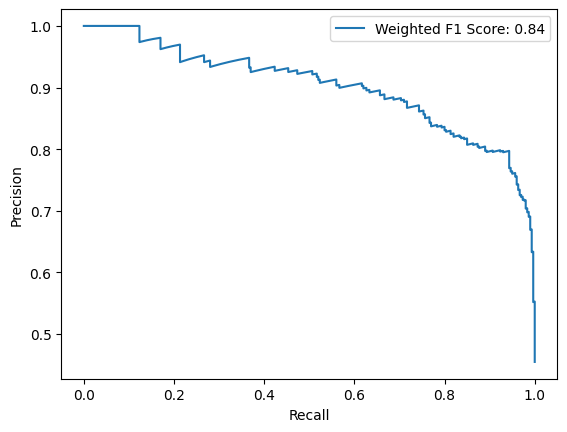

In [ ]:
precision, recall, _ = precision_recall_curve(test_generator.classes, predictions[:, 1])
f1 = f1_score(test_generator.classes, np.argmax(predictions, axis=1), average='weighted')
plt.plot(recall, precision, label=f'Weighted F1 Score: {f1:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

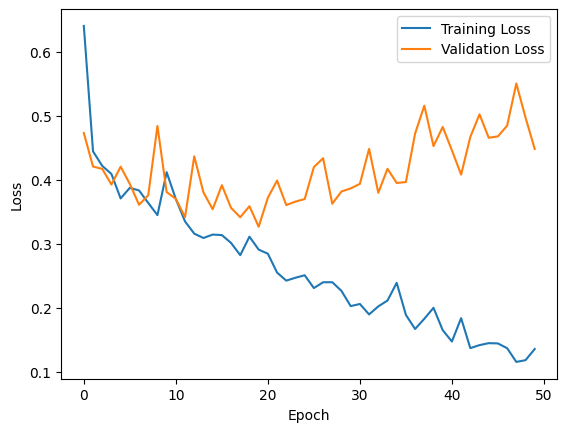

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 147ms/step


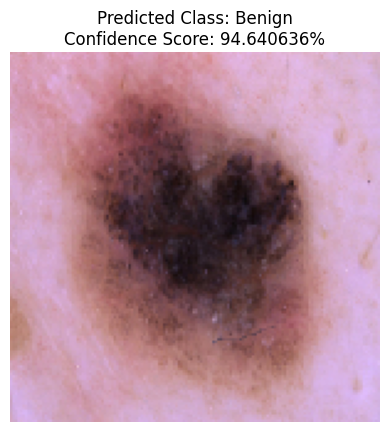

In [ ]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('best_model.h5')  # Provide the path to your saved model file

# Load and preprocess the image for prediction
img_path = '/content/test/benign/1166.jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale to match the training data

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class and confidence score
predicted_class = np.argmax(predictions[0])
confidence_score = predictions[0][predicted_class]

# Define class names based on your setup
class_names = ['Benign', 'Malignant', 'Other class']

# Display the image
plt.imshow(img)
plt.axis('off')

# Display the predicted class and confidence score
plt.title(f'Predicted Class: {class_names[predicted_class]}\nConfidence Score: {confidence_score:%}')
plt.show()